#Project# 1

# Inference Pipeline for Face Recognition Systems
- For detection of faces we will use MTCNN
- For the alignment, to maintain the simplicity of the scope of this kernel we will only use 2D alignment
- We will then use our model to extract the features

<img src='https://www.researchgate.net/publication/282863610/figure/fig1/AS:669508570214408@1536634690438/Processing-pipeline-of-face-recognition.jpg'>



*   *Develop a Face Recognition System Using
FaceNet for your classmate*
* **[3 pt]**   Collect a dataset for you and your classmate to do your system

* **[2 pt]** Do a Face_Verification function that verifies that the two images for the same person
  * The function Input is the path of two images.
  * It checks whether both images belong to the same person.
  * It returns "same Person" or "not same person" and the distance between them
  * recognition = Face_Verification("./image1.jpg",  "./image2.jpg")
* **[5 pt]**  Do a **Face_Recognition** A function that clusters an Image to a specific folder in a labeled database
  * The function Input is the image and folder path.
  * It returns a dictionary of the nearest label folders to the input image and its distance.
  * recognition = Face_Recognition("./test_image.jpg",  "./labeld_database")

---
**you may use these steps**

* Read an image and Detect the face
*  perform alignment
* Extract face embeddings
* Calculate the distance between embeddings present in the database and extracted input face embeddings
*  Find the index of the lowest distance, and check if the distance is less than a threshold
  * If yes then use the index to find the person from the database
  * Else the person in the input image is not present in the database
*  Use the OpenCV utilities to tag the person in the image
* cluster faces using SVM
* visualize each step

***I used Lab 6 part 4 alot as a reference to this project ***

In [15]:
!pip install keras-facenet
#Detect Faces
!pip install mtcnn

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import math
import cv2
import mtcnn

In [17]:
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from os import listdir
from os.path import join
import os
embedder = FaceNet()


# Read an image, Detect the Face, and perform allignment

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


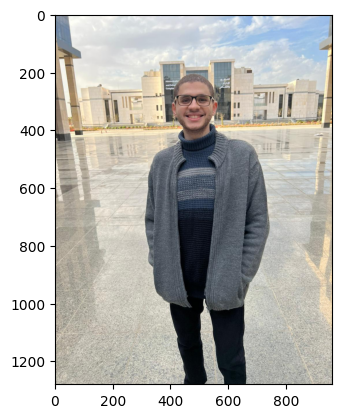

In [19]:
image = Image.open('/content/drive/MyDrive/Image Dataset/Train/Yahya/شسي.jpg')
plt.imshow(image)

1/1 [==============================] - 0s 292ms/step


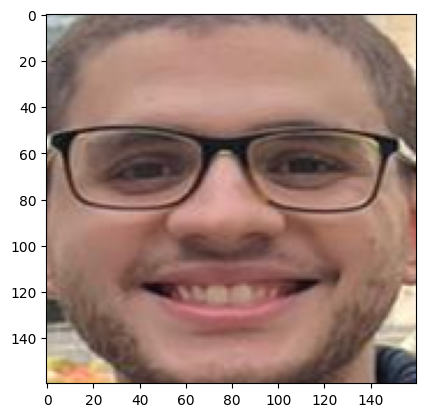

(160, 160, 3)


In [20]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('/content/drive/MyDrive/Image Dataset/Train/Yahya/شسي.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [21]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

# load train dataset
trainX, trainy = load_dataset('/content/drive/MyDrive/Image Dataset/Train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/drive/MyDrive/Image Dataset/Test/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('FacesDataset.npz', trainX, trainy, testX, testy)


4/4 [==============================] - 0s 32ms/step
loaded 7 sample for class: Yahya
1/1 [==============================] - 0s 160ms/step
loaded 5 sample for class: Omar Gaballah
1/1 [==============================] - 0s 160ms/step
loaded 5 sample for class: Ahmed Helmy
(17, 160, 160, 3) (17,)
1/1 [==============================] - 0s 281ms/step
loaded 6 sample for class: Yahya
1/1 [==============================] - 0s 217ms/step
loaded 4 sample for class: Omar Gaballah
1/1 [==============================] - 0s 170ms/step
loaded 5 sample for class: Ahmed Helmy
(15, 160, 160, 3) (15,)


In [22]:
# load the face dataset
data = np.load('FacesDataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (17, 160, 160, 3) (17,) (15, 160, 160, 3) (15,)


# Extract face embeddings

In [23]:
from keras_facenet import FaceNet

embedder = FaceNet()
# get the face embedding for one face
facenet_model=embedder.model

In [24]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]

# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)

emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('FacesDataset.npz', emdTrainX, trainy, emdTestX, testy)

1/1 [==============================] - 0s 95ms/step
(17, 512)
1/1 [==============================] - 0s 96ms/step
(15, 512)


In [25]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=17, test=15
Accuracy: train=100.000, test=100.000


Predicted: 
['Ahmed Helmy' 'Omar Gaballah' 'Yahya'] 
[ 6.42260971 14.35254182 79.22484848]
Expected: Yahya


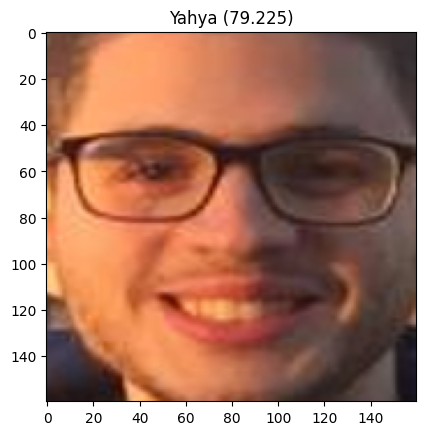

In [26]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

# Get the face embeddings


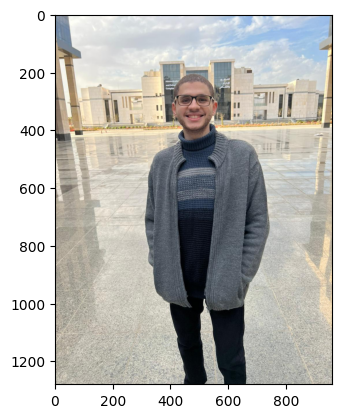

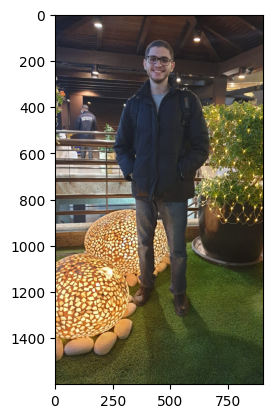

1/1 [==============================] - 0s 175ms/step
Same Person
0.16865581274032593


In [27]:
ii='/content/drive/MyDrive/Image Dataset/Train/Yahya/شسي.jpg'
jj='/content/drive/MyDrive/Image Dataset/Train/Yahya/IMG-20211217-WA0002.jpg'

# load image from file
image = Image.open(ii)
# convert to RGB, if needed
image = image.convert('RGB')
# convert to array
pixels = asarray(image)
plt.imshow(image)
plt.show()
# load image from file
image = Image.open(jj)
# convert to RGB, if needed
image = image.convert('RGB')
# convert to array
pixels = asarray(image)
plt.imshow(image)
plt.show()
detect_ii = embedder.extract(ii, threshold=0.95)
detect_jj = embedder.extract(jj, threshold=0.95)
dd = embedder.compute_distance(detect_ii[0]['embedding'], detect_jj[0]['embedding'])
if dd<.5:
  print('Same Person')
else: print ("different persons")
print(dd)

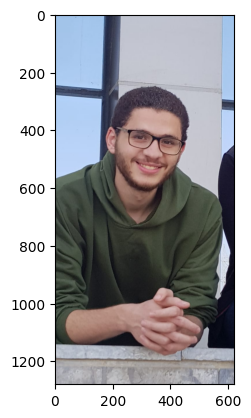

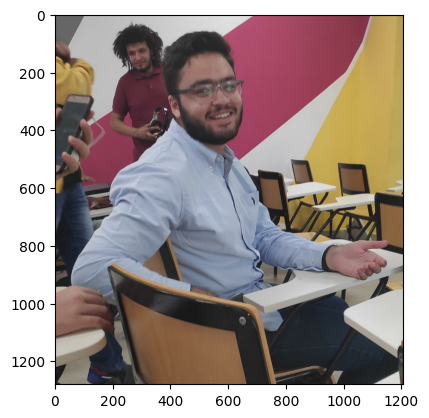

1/1 [==============================] - 0s 166ms/step
different persons
0.617128849029541


In [28]:
ii='/content/drive/MyDrive/Image Dataset/Test/Yahya/IMG-20200305-WA0007.jpg'
jj='/content/drive/MyDrive/Image Dataset/Test/Omar Gaballah/IMG-20191029-WA0006.jpg'

# load image from file
image = Image.open(ii)
# convert to RGB, if needed
image = image.convert('RGB')
# convert to array
pixels = asarray(image)
plt.imshow(image)
plt.show()
# load image from file
image = Image.open(jj)
# convert to RGB, if needed
image = image.convert('RGB')
# convert to array
pixels = asarray(image)
plt.imshow(image)
plt.show()
detect_ii = embedder.extract(ii, threshold=0.95)
detect_jj = embedder.extract(jj, threshold=0.95)
dd = embedder.compute_distance(detect_ii[0]['embedding'], detect_jj[0]['embedding'])
if dd<.5:
  print('Same Person')
else : print ("different persons")
print(dd)
